In [1]:
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'svg'

In [2]:
import restaurants_timeseries.core as core
import restaurants_timeseries.surveyors as surveyors

import GPy
import plotnine as pn
import pandas as pd
import numpy as np
from mizani.formatters import date_format

In [3]:
pn.options.figure_size = figure_size=(18, 4)
def plot_single_timeseries(dat):
    return (
        pn.ggplot(vs.visits, pn.aes('visit_date', 'visitors')) +
        pn.geom_line(pn.aes(group='air_store_id')) +
        pn.scale_x_date(breaks="1 week", labels=date_format("%b %d '%y")) +
        pn.theme_bw() +
        pn.theme(axis_text_x=pn.element_text(angle=90*3, size=9),
                 panel_grid=pn.element_blank()))
 

In [4]:
single_store_dat = (
    core.data['visits']
    .query(f"air_store_id == '{surveyors.populated_store_id}'")
    .copy())
vs = surveyors.VisitsSurveyor(single_store_dat, False)
vs.visits.loc[:, 'day'] = range(vs.visits.shape[0])

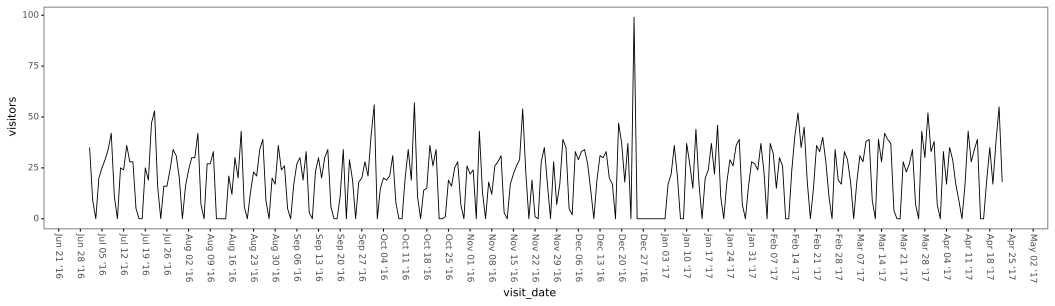

<ggplot: (8542376960380)>

In [5]:
plot_single_timeseries(vs.visits)

In [7]:
?GPy.kern.PeriodicExponential

Init signature: GPy.kern.PeriodicExponential(*args, **kw)
Docstring:     
Kernel of the periodic subspace (up to a given frequency) of a exponential
(Matern 1/2) RKHS.

Only defined for input_dim=1.
Init docstring:
:type input_dim: int
:param variance: the variance of the Matern kernel
:type variance: float
:param lengthscale: the lengthscale of the Matern kernel
:type lengthscale: np.ndarray of size (input_dim,)
:param period: the period
:type period: float
:param n_freq: the number of frequencies considered for the periodic subspace
:type n_freq: int
:rtype: kernel object
File:           /opt/conda/lib/python3.8/site-packages/GPy/kern/src/periodic.py
Type:           KernCallsViaSlicerMeta
Subclasses:     


In [37]:
X = vs.visits[['day']].to_numpy()
base_kernel = GPy.kern.RBF(input_dim=X.shape[1], variance=10.0, lengthscale=1.0)
periodic_kernel = GPy.kern.PeriodicMatern32(input_dim=1, variance=1., period=7.0)
kernel = base_kernel + periodic_kernel
y = vs.visits[['visitors']].to_numpy()

In [38]:
m = GPy.models.GPRegression(X, y, kernel)

{'dataplot': [<matplotlib.collections.PathCollection at 0x7c4ebee929d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7c4ebee92f40>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7c4ebeea2250>]}

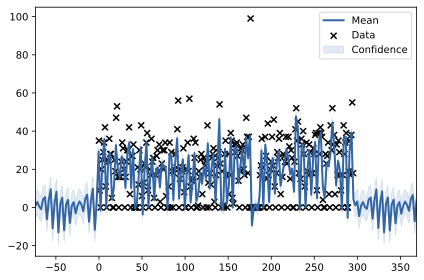

In [39]:
m.plot()

In [40]:
p = m.predict(X)
means = [x[0] for x in p[0]]
variance = [x[0] for x in p[1]]
days = [x[0] for x in X]

In [41]:
pred_dat = pd.DataFrame({'day': days, 'mean': means, 'var': variance, 'sd': np.sqrt(variance)})
pred_dat.loc[:, 'mean'] = np.maximum(0.0, pred_dat['mean'])
pred_dat.loc[:, 'lower_bound'] = np.maximum(0.0, pred_dat['mean'] - 2 * pred_dat['sd'])
pred_dat.loc[:, 'upper_bound'] = np.maximum(0.0, pred_dat['mean'] + 2 * pred_dat['sd'])

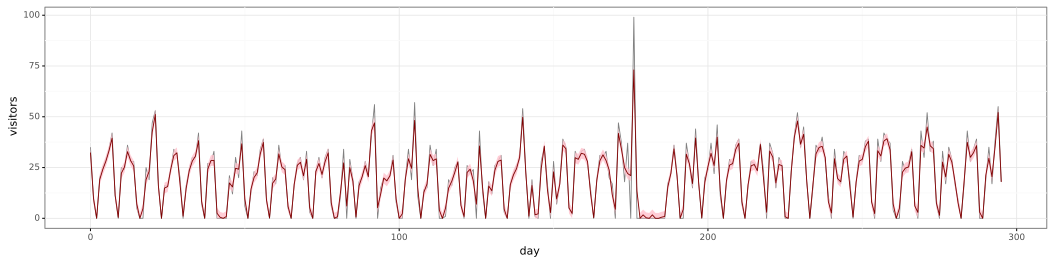

<ggplot: (8542375675215)>

In [44]:

(
    pn.ggplot() +
    pn.geom_line(data=vs.visits, mapping=pn.aes('day', 'visitors'), color='gray') +
    pn.geom_ribbon(data=pred_dat, mapping=pn.aes(x='day', ymax='upper_bound', ymin='lower_bound'), 
                   fill='pink', alpha=0.8) +
    pn.geom_line(data=pred_dat, mapping=pn.aes(x='day', y='mean'), color='maroon') +
    pn.theme_bw())